In [30]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as mtick
import matplotlib.cm as cm
import math
import plotly.graph_objects as go
from collections import OrderedDict
from matplotlib.lines import Line2D  # Import for creating custom legend markers
import json
import copy
import random
import re
import seaborn as sns
import importlib


# Import BW25 packages
import bw2data as bd
import bw2io as bi
import bw2calc as bc
import bw2analyzer as bwa
import brightway2 as bw 
from bw2calc import LeastSquaresLCA

In [31]:
from  standards import *
import Monte_Carlo as MC
import life_cycle_assessment as lc


importlib.reload(MC)

importlib.reload(lc)

Folder name Results created


<module 'life_cycle_assessment' from 'c:\\Users\\ruw\\Desktop\\RA\\Single-use-vs-multi-use-in-health-care\\Brighway\\life_cycle_assessment.py'>

In [32]:
db_type = 'CONSQ'

save_dir = results_folder('Results')

file_name = f'Results\Ananas - {db_type}.xlsx'
file_cont_name = f'Results\Ananas contribution - {db_type}.xlsx'
sheet_name = 'Ananas'

path = r'C:\Users\ruw\Desktop\RA\Single-use-vs-multi-use-in-health-care\Brighway'

# Your name variable should be the name of the project.
database_project = "RA - Ofir & Stine 1"
database_name = "Ananas consq"

flows = [f'alubox - {db_type}', f'PP sheet sc2 - {db_type}', f'PP sheet sc3 - {db_type}']
flow_legend = [f'alubox - {db_type} sc1', f'PP sheet sc2 - {db_type}', f'PP sheet sc3 - {db_type}']


Folder name Results created


In [33]:
FU, FU_proc, impact_category, plot_x_axis, sub_product_details = lc.LCA_initialization(database_project, database_name, flows)
impat =  impact_category

calculate = False

if f'{path}\{sheet_name}' is False or calculate is True:
    # Caculating the LCA results
    df = lc.life_cycle_impact_assessment(flows, FU, impat, FU_proc)
    lc.save_LCA_results(df, file_name, sheet_name, impat)


df_test = lc.import_LCA_results(file_name, flows, impat)

Biosphere database already present!!! No setup is needed
Initialization is completed


In [34]:
# # Processing the LCA results
sub_proccess, amount = lc.obtaining_sub_process(sub_product_details)
FU_sub, FU_sub_process, idx = lc.sub_process_initilization(sub_proccess, FU, database_project, 'df_idx_ofir')
flow_count, flow_sub, functional_unit_sub = lc.FU_contibution_initilization(FU_sub, FU_sub_process)


Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initialization is completed
Biosphere database already present!!! No setup is needed
Initiali

In [35]:
fu_sub_updated = lc.process_update(FU, functional_unit_sub)
fu_sub_updated

[[{'alubox raw materials - CONSQ': {'market for aluminium, wrought alloy' (kilogram, GLO, None): 3.592}},
  {'alubox raw materials - CONSQ': {'steel production, chromium steel 18/8, hot rolled' (kilogram, RER, None): 0.742}},
  {'alubox production - CONSQ': {'anodising, aluminium sheet' (square meter, RER, None): 0.7389}},
  {'alubox production - CONSQ': {'impact extrusion of aluminium, 4 strokes' (kilogram, RER, None): 3.592}},
  {'alubox production - CONSQ': {'corrugated board box production' (kilogram, RER, None): 0.46927374301676}},
  {'alubox production - CONSQ': {'metal working, average for chromium steel product manufacturing' (kilogram, RER, None): 0.742}},
  {'alubox production - CONSQ': {'sheet rolling, aluminium' (kilogram, RER, None): 3.592}},
  {'autoclave - CONSQ': {'autoclave - CONSQ' (unit, GLO, None): 0.1111111111111111}},
  {'Handwash - CONSQ': {'Handwash - CONSQ' (unit, GLO, None): 1}},
  {'alubox EoL melting - CONSQ': {'treatment of metal scrap, mixed, for recycling

In [36]:
# df_cont = lc.LCIA_contribution(impat[1], flow_count, FU_sub_process, fu_sub_updated, amount, idx)

In [37]:
# lc.save_LCA_results(df_cont, file_cont_name, sheet_name, impat)

In [38]:
df_c = lc.import_LCA_results(file_cont_name, idx, impact_category[1])
# lc.save_LCA_results(df_x, file_cont_name, sheet_name, impat)

In [39]:
df_tot, df_scaled, df_cols = lc.dataframe_element_scaling(df_test)
index_list = list(df_scaled.index.values)
plt_leg = lc.dataframe_column_structure(impat)

In [40]:
df_GWP = df_test[df_test.columns[1]].to_frame()
df_GWP

,EF v3.1 EN15804
,climate change
,global warming potential (GWP100)
alubox - CONSQ,"[[alubox raw materials - CONSQ, 0.154243928226..."
PP sheet sc2 - CONSQ,"[[pp production - CONSQ, 0.2294040394877444], ..."
PP sheet sc3 - CONSQ,"[[pp production - CONSQ, 0.2294040394877444], ..."


In [41]:
x_axis = []
GWP_value = []

# gwp_tot = [0] * len(df_updated)
for df_size in range(len(df_GWP)):
    lst_x = []
    lst_GWP = []
    gwp_tot = 0
    for key in df_GWP.keys():
        for lst_size in range(len(df_GWP[key][df_size])):
            #print(df_size, lst_size)
            x = df_GWP[key][df_size][lst_size][0]
            gwp = df_GWP[key][df_size][lst_size][1]
            
            #print(gwp,x)
            if f'- {db_type}' in x:
                #print(key)
                x = x.replace(f' - {db_type}', '')
            if 'alubox' in x:           
                x = x.replace('alubox ', '')
                if 'raw' in x and 'avoid' not in x.lower():
                    x = x.replace('raw materials', 'Raw mat.')
                elif 'raw' in x and 'avoid' in x:
                    x = 'Avoided virgin mat.'
                if 'production' in x:
                    x = 'Production'
            if 'Waste' in x:
                x = 'Incineration'
                
            if 'market for electricity' in x:
                x = 'Avoided electricity'
            if 'heating' in x:
                x = 'Avoided heat'
            if 'market for polypropylene' in x:
                x = 'PP granulate'
            if 'PE granulate' in x:
                x = 'PE granulate'
            if 'no Energy Recovery' in x:
                x = x.replace(' no Energy Recovery', '')
                # print(x)
                # gwp = - gwp
            if 'board box' in x:
                x = 'Cardboard box'
            if 'packaging film' in x:
                x = 'PE packaging film prod.'
            if 'pp' in x:
                x = x.replace('pp', 'PP')
            if 'autoclave' in x:
                x = x.replace('autoclave', 'Autoclave')
            if 'transport' in x:
                x = 'Transport'

            lst_x.append(x)
            lst_GWP.append(gwp)
            gwp_tot += gwp
            print(x, gwp)
    # print(gwp_tot, lst_GWP)
    lst_GWP.append(gwp_tot)
    lst_x.append('Total')
    x_axis.append(lst_x)
    GWP_value.append(lst_GWP)



Raw mat. 0.1542439282263658
Production 0.022156774023127858
Autoclave 0.13321320200128806
Handwash 0.02337939003610922
EoL melting 0.13106909346835469
EoL mixed sorting 0.0031809502666867344
Transport 0.0021324672022102766
Avoided virgin mat. -0.1434851961755121
PP production 0.2294040394877444
Autoclave 0.13321320200128806
Cardboard box -0.001643952509815517
PE packaging film prod. 0.025384539441210368
PP granulate 0.17825063717676437
Avoided electricity -0.005961318604063036
Transport 0.06076427765999239
PE incineration 0.030393167090317762
PP incineration 0.22231429048710702
Avoided heat -0.15272040513522483
PP production 0.2294040394877444
Autoclave 0.13321320200128806
Cardboard box -0.001643952509815517
PE packaging film prod. 0.025384539441210368
PP granulate 0.17825063717676437
PE granulate -0.011359305107549338
PP granulate -0.09625534407615824
Avoided electricity -0.002742206557869834
Transport 0.06076427765999239
PE incineration 0.013980856861540856
PP incineration 0.10226457

C:\Users\ruw\AppData\Local\Temp\6\ipykernel_17012\2337081773.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  for lst_size in range(len(df_GWP[key][df_size])):
C:\Users\ruw\AppData\Local\Temp\6\ipykernel_17012\2337081773.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = df_GWP[key][df_size][lst_size][0]
C:\Users\ruw\AppData\Local\Temp\6\ipykernel_17012\2337081773.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gwp = 

In [42]:
# Categories definitions
categories = ["Raw mat. + prod.", "Use", "Transport", "EoL", "Total"]
category_mapping = {
    "Raw mat. + prod.": ["PP production", "Cardboard box", "Scalpel", "Raw mat.", "Production"],
    "Use": ["Autoclave", "disinfection", "Handwash", "Remanufacturing"],
    "Transport": ["Transport"],
    "EoL": ["PP incineration", "PE incineration", "Avoided heat", "Avoided electricity", "EoL melting", "EoL mixed sorting", "Avoided virgin mat."],
    "Total": ["Total"]
}

# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                # print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
                if x_axis[x_lst][x] in item:
                    # print(x_axis[x_lst][x], item, x_lst, x)
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            # print(val)
            plot_legend[key].append(val)


colors = plot_colors(temp,'turbo')


In [43]:
columns_to_plot = df_scaled.columns

In [44]:
plt_leg = lc.dataframe_column_structure(impact_category)


In [45]:
def round_down(value):
    # https://stackoverflow.com/questions/41383787/round-down-to-2-decimal-in-python
    value = math.floor(value * 10)/10.0
    return value

In [46]:
round_down(-1.43)

-1.5

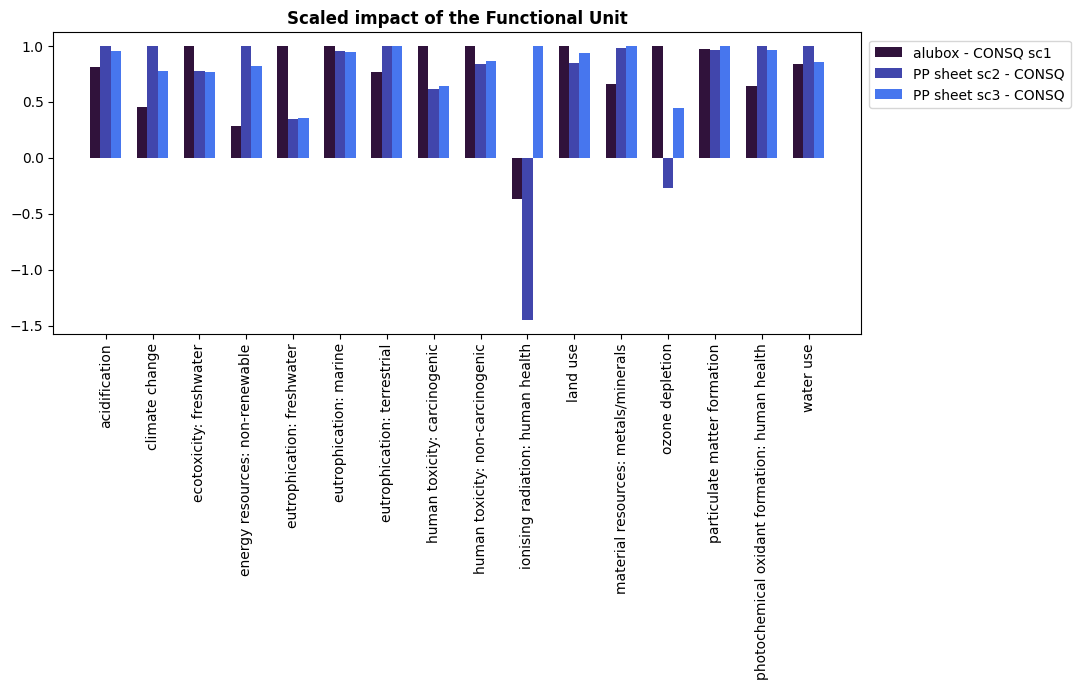

In [47]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(df_scaled)
bar_width = 1/(len(index_list) + 1.5) 
index = np.arange(len(columns_to_plot))

# Plotting each group of bars
min_val = 0
for i, process in enumerate(df_scaled.index):
    values = df_scaled.loc[process, columns_to_plot].values
    ax.bar((index + i * bar_width), values, bar_width, label=process, color=colors[i])  
    # print(min(values))
    if min_val > min(values):
        min_val = min(values)


# Setting labels and title
ax.set_title('Scaled impact of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(plot_x_axis)
plt.xticks(rotation=90)
# plt.yticks(np.arange(-1.6, 1.01, step=0.2))
# plt.ylim(-1.52,1.03)

ax.legend(flow_legend,bbox_to_anchor=(1.01, .75, .25, 0), loc="lower left",
            mode="expand", borderaxespad=0,  ncol=1)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, f'scaled_impact_score_multi_{db_type}.jpg'), bbox_inches='tight')
plt.show()

In [48]:
directory = 'C:\\Users\\ruw\\Desktop\\RA\\'
lst_scaled = lc.LCIA_normalization(directory, df_tot)

In [49]:
lst_scaled

[0.652839363046289, 1.0, 0.9004138162205947]

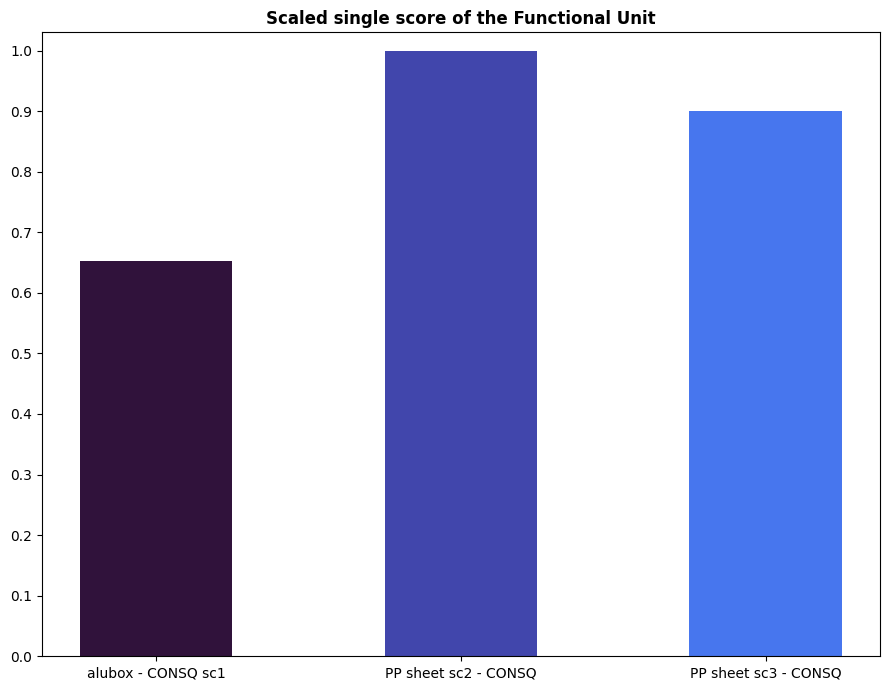

In [50]:
# Plotting
fig, ax = plt.subplots(figsize=(9,7))

num_processes = len(lst_scaled)
bar_width = 1/(len(index_list)-1) 
index = np.arange(len(index_list))   

ax.bar(index + bar_width, lst_scaled, bar_width, label=index_list, color=colors)

# Setting labels and title
ax.set_title('Scaled single score of the Functional Unit',weight='bold')
ax.set_xticks(index + bar_width )
ax.set_xticklabels(flow_legend)
#plt.xticks(rotation=90)
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.ylim(0,1.03)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, f'scaled_single_score_multi_{db_type}.jpg'), bbox_inches='tight')
plt.show()

In [51]:
# Ensure the legend displays items in the category order
ordered_legend = {key: [] for key in category_mapping}

for x_lst in range(len(x_axis)):
    for x in range(len(x_axis[x_lst])):
        
        for key, item in category_mapping.items():
                #print(x_axis[x_lst][x], item, x_axis[x_lst][x] in item)
                if x_axis[x_lst][x] in item:
                    # print(x_axis[x_lst][x], item, x_lst, x)
                    ordered_legend[key].append(x_axis[x_lst][x])

plot_legend = {key: [] for key in category_mapping}
temp = []

for key,value in ordered_legend.items():
    #print(key, value)
    for val in value:
        if val not in temp:
            temp.append(val)
            # print(val)
            plot_legend[key].append(val)

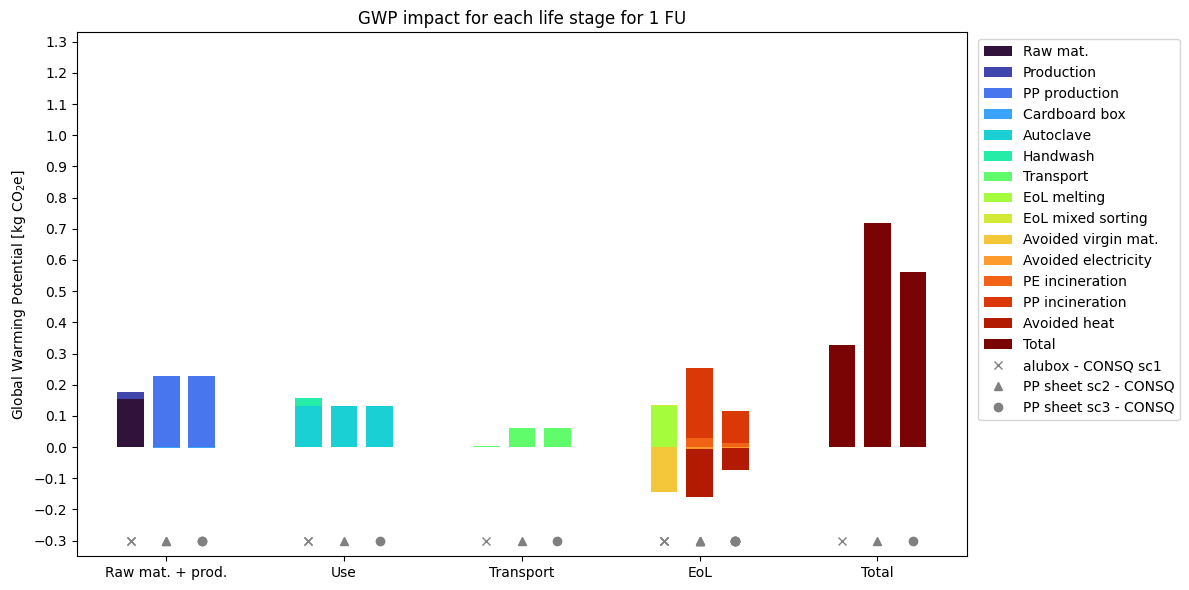

In [52]:

color_map = {}
#unique_processes = {process for sublist in x_axis for process in sublist}
for i, process in enumerate(temp):
    color_map[process] = colors[i]
    #print(process, i)



# Initialize an ordered dictionary for legend_handles to maintain the order
legend_handles = OrderedDict()

# Initialize legend_handles with keys from plot_legend and empty lists
for process in temp:
    legend_handles[process] = None

# Plotting logic
if len(x_axis) == len(GWP_value):
    num_scenarios = len(GWP_value)  # Number of scenarios
    bar_width = 0.15  # Width of the bars for each scenario
    space_between_scenarios = 0.05  # Space between each scenario set
    index = np.arange(len(categories))  # X-axis index positions for the categories

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    idx = ['x', '^', 'o']  # List of markers for scenarios
    all_markers = []  # List to store Line2D objects for markers

    # Main plotting logic
    for scenario in range(num_scenarios):
        bottom_positive = np.zeros(len(categories))  # Initialize the bottom array for positive values
        bottom_negative = np.zeros(len(categories))  # Initialize the bottom array for negative values
        scenario_index = index + scenario * (bar_width + space_between_scenarios)

        for length in range(len(x_axis[scenario])):
            process_name = x_axis[scenario][length]
            value = GWP_value[scenario][length]

            # Determine which category this process falls into
            for i, category in enumerate(categories):
                if any(keyword in process_name for keyword in category_mapping[category]):
                    # Assign color based on the process name
                    color = color_map[process_name]

                    # Create a bar with the specific color
                    if value >= 0:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_positive[i],
                                    color=color)
                        bottom_positive[i] += value
                    else:
                        bar = ax.bar(scenario_index[i], value, bar_width,
                                    label=f"{process_name}" if legend_handles[process_name] is None else "",
                                    bottom=bottom_negative[i],
                                    color=color)
                        bottom_negative[i] += value

                    # Add the bar to the corresponding process in legend_handles
                    if legend_handles[process_name] is None:
                        legend_handles[process_name] = bar

                    # Add plot markers (symbols) at the bottom
                    ax.plot(scenario_index[i], -0.3, marker=idx[scenario], color='gray')

                    break

    # Add custom markers to the legend
    for i, marker in enumerate(idx):
        all_markers.append(Line2D([0], [0], marker=marker, color='gray', label=f'Scenario {i + 1}', linestyle='None'))

    # Set x-axis labels and ticks, adjusting to account for spacing
    tick_positions = index + (num_scenarios - 1) * (bar_width + space_between_scenarios) / 2
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(categories)

    # Axis limits
    ax.set_ylim(-.35, 1.33)
    ax.set_yticks(np.arange(-0.3, 1.31, step=0.1))
    ax.set_ylabel("Global Warming Potential [kg CO$_2$e]")
    ax.set_title('GWP impact for each life stage for 1 FU')

    # Add markers to legend_handles for display at the bottom of the legend
    valid_legend_handles = [(k, v) for k, v in legend_handles.items() if v is not None]
    legend_handles_for_display = valid_legend_handles + [(flow_legend[i], marker) for i, marker in enumerate(all_markers)]

    if legend_handles_for_display:
        ax.legend(handles=[v for k, v in legend_handles_for_display], labels=[k for k, v in legend_handles_for_display], bbox_to_anchor=(1.005, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'GWP_life_stage_{db_type}.jpg'), bbox_inches='tight')
    plt.show()
    

else:
    print('The x-axis and GWP values have different sizes')


In [53]:
def node_name_update(node):
    if '- APOS - sc 1' in node:
        node = node.replace(f' - APOS - sc 1', '')
        if  'avoided alubox raw materials' in node:
            node = 'Avoided raw mat.'
        elif 'melting' in node:
            node = 'Melting'
        elif 'mixed sorting' in node:
            node = 'Mixed sorting'
        elif 'prod' in node:
            node = 'Alubox prod.'
        else:
            node = node.title()
    elif 'wrought alloy' in node:
        node = 'Virgin alu'
    elif 'steel production' in node:
        node = 'Virgin steel'
    elif 'impact extrusio' in node:
        node = 'Alu impact extrusion'
    elif 'corrugated' in node:
        node = 'Cardboard box'
    elif 'anodising' in node:
        node = 'Alu anodising'
    elif 'transport' in node:
        node = 'Transport'
    
    return node

In [54]:
def source_name_update(process, source):
        
    if 'wrought alloy' in source:
        source = 'Alu wrought alloy'
    elif 'steel production' in source:
        source = 'Virgin steel'
    elif 'anodising' in source:
        source = 'Alu anodising'
    elif 'impact extrusio' in source:
        source = 'Alu impact extrusion'
    elif 'transport' in source:
        source = 'Transport'
    elif 'corrugated' in source:
        source = 'Cardboard box'
    elif 'metal working' in source:
        source = 'Steel manufacturing'
    elif 'sheet rolling' in source:
        source = 'Alu sheet rolling'
    elif 'recycling' in source:
        if 'mixed sorting' in process.lower():
            source = 'Mixed metal scrap'
        else:
            source = 'Alu remelting'
    elif 'autoclave' in source:
        source = 'Autoclave'
    elif 'Handwash' in source:
        source = 'Handwash'
    return source

In [55]:
df_c_gwp =copy.deepcopy(df_c)
c = []

node_sc1 = ['Raw material','Production', 'Use', 'EoL', 'EoL Treatment']
node_sc2 = []
node_sc3 = []

links_sc1 = []
links_sc2 = []
links_sc3 = []

for i, row in df_c_gwp.iterrows():
    if 'sc 1' in i:
        # print(i)
        node = node_name_update(i)
        # if  'disinfec' not in i:
        node_sc1.append(node)
        for element in row:

            for proc in element:
                # print(proc)
                val = round(proc[1]/GWP_value[0][-1]*100,2)
                source = proc[0]
                source = source_name_update(i,source)
                # print(source)
                if   val != 0:

                    if  val < 0 and 'Cardboard' not in source:
                        # print(proc[0])
                        source = 'Avoided ' + source.lower()

                    if 'raw material' in i and 'avoided' not in source.lower():
                        print(f'{i} : Raw : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Raw material', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'Production', "value":val}
                        # dct_temp3 = {"source": node, "target": 'Production', "value":val}
                    if 'production' in i or 'transport' in source.lower():
                        print(f'{i} : Prod. : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Production', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'Use', "value":val}
                        # dct_temp3 = {"source": node, "target": 'Use', "value":val}
                    if 'autoclave' in i.lower() or 'handwash' in i.lower():
                        print(f'{i} : Use : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Use', "target": source, "value": val}
                        dct_temp2 = {"source": source, "target": 'EoL', "value": val}
                    if  'avoided' in i.lower():
                        
                        if 'alu' in source.lower():
                            val = round(val * 0.95, 2) 
                        elif 'steel' in source.lower():
                            val = round(val * 0.65, 2) 
                        print(f'{i} : EoL : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'EoL', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": node, "value":val}
                    if 'eol' in i.lower() and 'avoided' not in i.lower():
                        print(f'{i} : EoL : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'EoL', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'EoL Treatment', "value":val}

                
                    links_sc1.append(dct_temp)
                    links_sc1.append(dct_temp2)
                    # if dct_temp3 not in links_sc1:
                    #     links_sc1.append(dct_temp3)
                    node_sc1.append(source)


alubox raw materials - CONSQ - sc 1 : Raw : alubox raw materials - CONSQ - sc 1, source : Alu wrought alloy, GWP : 44.21
alubox raw materials - CONSQ - sc 1 : Raw : alubox raw materials - CONSQ - sc 1, source : Virgin steel, GWP : 3.12
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu anodising, GWP : 1.27
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu impact extrusion, GWP : 2.94
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Cardboard box, GWP : -0.08
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Steel manufacturing, GWP : 1.22
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu sheet rolling, GWP : 1.46
autoclave - CONSQ - sc 1 : Use : autoclave - CONSQ - sc 1, source : Autoclave, GWP : 4.54
Handwash - CONSQ - sc 1 : Use : Handwash - CONSQ - sc 1, source : Handwash, GWP : 7.17
alubox Eo

In [56]:
colors

[(0.18995, 0.07176, 0.23217, 1.0),
 (0.25618, 0.27412, 0.67381, 1.0),
 (0.27698, 0.46153, 0.93309, 1.0),
 (0.22676, 0.63913, 0.98851, 1.0),
 (0.10738, 0.81381, 0.83484, 1.0),
 (0.14391, 0.9268, 0.65448, 1.0),
 (0.38127, 0.98909, 0.42386, 1.0),
 (0.64362, 0.98999, 0.23356, 1.0),
 (0.82333, 0.91253, 0.20663, 1.0),
 (0.9556, 0.78005, 0.22836, 1.0),
 (0.99672, 0.60977, 0.17842, 1.0),
 (0.95398, 0.38836, 0.08362, 1.0),
 (0.8538, 0.2217, 0.02677, 1.0),
 (0.6965, 0.10102, 0.00522, 1.0),
 (0.4796, 0.01583, 0.01055, 1.0)]

In [57]:
color_links = []
color_nodes = []
for c in colors:
    c_link = list(c)  # Convert tuple to list if needed
    c_node = list(c)

    c_link = f"rgba({c[0]}, {c[1]}, {c[2]}, .5)"  # Update the last element
    c_node = f"rgba({c[0]}, {c[1]}, {c[2]}, 1)"

    color_links.append(c_link)  # Add the updated list to c_new
    color_nodes.append(c_node)

c_node

'rgba(0.4796, 0.01583, 0.01055, 1)'

In [58]:
sankey_color = colors



In [59]:
list(sankey_color[0])

[0.18995, 0.07176, 0.23217, 1.0]

In [60]:
len(color_nodes)

15

In [61]:
df_c_gwp =copy.deepcopy(df_c)
c = []

node_sc1 = ['Raw material','Production', 'Use', 'EoL', 'EoL Treatment']
node_sc2 = []
node_sc3 = []



links_sc1 = []
links_sc2 = []
links_sc3 = []

node_colors_links = {}
node_colors = {}

link_opacity = 0.3
node_opacity = 0.9

pos = -3
neg = 6

for i, c in enumerate(node_sc1):
    node_colors_links[c] =color_links[pos]
    if i == 0:
        node_colors[c] = color_nodes[i+1]
    else:
        node_colors[c] = color_nodes[i+4]

for i, row in df_c_gwp.iterrows():
    if 'sc 1' in i:
        # print(i)
        node = node_name_update(i)
        # if  'disinfec' not in i:
        node_sc1.append(node)
        for element in row:

            for proc in element:
                # print(proc)
                val = round(proc[1]/GWP_value[0][-1]*100,2)
                source = proc[0]
                source = source_name_update(i,source)
                # print(source)
                if   val != 0:
                    node_colors_links[source] = color_links[pos]
                    if  val < 0 and 'Cardboard' not in source:
                        # print(proc[0])
                        source = 'Avoided ' + source.lower()

                        node_colors_links[source] = color_links[neg]

                    if 'raw material' in i and 'avoided' not in source.lower():
                        print(f'{i} : Raw : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Raw material', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'Production', "value":val}
                        # dct_temp3 = {"source": node, "target": 'Production', "value":val}
                        node_colors[source] = color_nodes[2]
                        node_colors[node] = color_nodes[0]

                    if 'production' in i or 'transport' in source.lower():
                        print(f'{i} : Prod. : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Production', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'Use', "value":val}
                        # dct_temp3 = {"source": node, "target": 'Use', "value":val}
                        node_colors[source] = color_nodes[5]
                        node_colors[node] = color_nodes[6]

                    if 'autoclave' in i.lower() or 'handwash' in i.lower():
                        print(f'{i} : Use : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'Use', "target": source, "value": val}
                        dct_temp2 = {"source": source, "target": 'EoL', "value": val}
                        node_colors[source] = color_nodes[4]
                        node_colors[node] = color_nodes[3]
                        
                    if  'avoided' in i.lower():
                        if 'alu' in source.lower():
                            val = round(val * 0.95, 2) 
                        elif 'steel' in source.lower():
                            val = round(val * 0.65, 2) 
                        print(f'{i} : EoL : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'EoL', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": node, "value":val}
                        node_colors[source] = color_nodes[13]
                        node_colors[node] = color_nodes[11]
                        
                    if 'eol' in i.lower() and 'avoided' not in i.lower():
                        print(f'{i} : EoL : {node}, source : {source}, GWP : {val}')
                        dct_temp = {"source": 'EoL', "target": source, "value":val}
                        dct_temp2 = {"source": source, "target": 'EoL Treatment', "value":val}
                        node_colors[source] = color_nodes[13]
                        node_colors[node] = color_nodes[11]
                
                    links_sc1.append(dct_temp)
                    links_sc1.append(dct_temp2)
                    # if dct_temp3 not in links_sc1:
                    #     links_sc1.append(dct_temp3)
                    node_sc1.append(source)


alubox raw materials - CONSQ - sc 1 : Raw : alubox raw materials - CONSQ - sc 1, source : Alu wrought alloy, GWP : 44.21
alubox raw materials - CONSQ - sc 1 : Raw : alubox raw materials - CONSQ - sc 1, source : Virgin steel, GWP : 3.12
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu anodising, GWP : 1.27
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu impact extrusion, GWP : 2.94
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Cardboard box, GWP : -0.08
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Steel manufacturing, GWP : 1.22
alubox production - CONSQ - sc 1 : Prod. : alubox production - CONSQ - sc 1, source : Alu sheet rolling, GWP : 1.46
autoclave - CONSQ - sc 1 : Use : autoclave - CONSQ - sc 1, source : Autoclave, GWP : 4.54
Handwash - CONSQ - sc 1 : Use : Handwash - CONSQ - sc 1, source : Handwash, GWP : 7.17
alubox Eo

In [62]:
len(colors)

15

In [63]:

# Create a Sankey diagram
fig = go.Figure()

# Calculate the scale factor for link thickness and node size
max_value = max(abs(link['value']) for link in links_sc1)
scale_factor = 1  # You can adjust this factor to control the scaling

# Calculate total outflow for each node and round to 2 decimals
outflow_totals = {node: round(sum(link['value'] for link in links_sc1 if link['source'] == node), 2) for node in node_sc1}

# Calculate total inflow for each node and round to 2 decimals
inflow_totals = {node: round(sum(link['value'] for link in links_sc1 if link['target'] == node), 2) for node in node_sc1}

# Determine if a node has only incoming flows
incoming_only = {node: inflow_totals[node] > 0 and outflow_totals[node] == 0 for node in node_sc1}

# Calculate y-coordinates for nodes based on total outflow or inflow
node_y_coordinates = [sum(inflow_totals[node] if incoming_only[node] else outflow_totals[node] for node in node_sc1[:i]) for i in range(len(node_sc1))]
incoming_only['Avoided raw mat.'] = True
incoming_only['EoL Treatment'] = True
# incoming_only['Avoided chromium steel'] = True

# Add links
fig.add_trace(go.Sankey(
    node=dict(
        pad=50,
        thickness=10,
        line=dict(width=[abs(link['value']) / max_value * scale_factor for link in links_sc1]),
        label=[f"{node}<br>{inflow_totals[node] if incoming_only[node] else outflow_totals[node]}%" for node in node_sc1],
        color=[node_colors[node] for node in node_sc1],
    ),
    link=dict(
        source=[node_sc1.index(link['source']) for link in links_sc1],
        target=[node_sc1.index(link['target']) for link in links_sc1],
        value=[abs(link['value']) for link in links_sc1],
        color=[node_colors_links[link['source']] for link in links_sc1],  # Use source node color for links
        line=dict(width=[abs(link['value']) / max_value * scale_factor for link in links_sc1]),
    ),
    arrangement="perpendicular",
    domain=dict(x=[0, 1], y=[0, 1]),
))


# Show the figure
fig.show()
# fig.write_image("Sankey_alubox_consq.jpg")
